In [1]:
############################################################
########### Method: Artificial Neural Network (ANN) ########
############################################################
import numpy as np
import matplotlib.pyplot as plt
import math
from netCDF4 import Dataset
import json
from datetime import datetime
from functionsANN import *
from datetime import datetime
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
# np.random.seed(42)

num_cores = multiprocessing.cpu_count()
print('Number of cores:',num_cores)

# Define other parameters of the problem
n_pc = 150         # number of PCs
n_record = 50000   # total records
n_maxtrain = 40000 # maximum possible length of training data
n_test = n_record - n_maxtrain # length of the test data
test0_idx = n_maxtrain              # test data start index
dt = 10            # temporal resolution

#### Load the pcs ####
f = 'psi1_DG_0_500K_100days_filtered_150PCs.dat'
fpath = os.getcwd() + '/../' + f
pcs = dlmread(fpath, n_record, n_pc)
pcs = center(pcs)
# get the test dataset
test_data = pcs[test0_idx:test0_idx+n_test, :]
 
#### Load the EOFs ####
nx = 513; ny=513
eoffile = os.getcwd() + '/../psi1_DG_0_500K_100days_filtered_150EOFs.nc'
fid = Dataset(eoffile,'r')
eofs = fid.variables['EOFs'][:n_pc,:,:]
eofs = eofs.reshape((n_pc, nx*ny))

Using TensorFlow backend.


Number of cores: 24


In [ ]:
##################################################################
### Sensitivity analysis of training length to the performance ###
##################################################################
# check the RMSE on the test data for next time step forecast

n_mintrain = 1000
n_train_inc = 1000

n_train = np.arange(n_mintrain, n_maxtrain+1, n_train_inc, dtype='int')
rmse_test = np.zeros((len(n_train), n_pc)) 

hyperparams = {'activation':'tanh', 'npl':100, 
               'loss':'mse', 'optimizer':'adam',
               'metric':'mse', 'epochs':20,
               'numhidlayers':2,'validation_split':0.2}

ypred_ANN = np.zeros((n_test, n_pc))

for i, trainlen in enumerate(n_train):
    print('Training length:',trainlen)
    # prepare the training data
    [x_train, y_train, scaler] = trainingdata(pcs, n_pc, trainlen, 'standard_top_pc')
    # perform ANN
    model, history = ANN(x_train, y_train, n_pc, **hyperparams)
    # check the performance on the test dataset
    normalized_test_data = scaler.transform(test_data)
    for k in range(n_test):
        ypred_ANN[k,:] = model.predict(np.reshape(normalized_test_data[k,:], [1,-1]), batch_size=1)
    # compute the rms error
    rmse_test[i,:] = np.sum((ypred_ANN[:-1,:] - normalized_test_data[1:,:])**2, axis=0) 

# Analyze RMSE on the test dataset for each training length
#for i in range(n_pc):
#    plt.scatter(n_train, rmse_test[:,i], color='b', alpha=0.1)
plt.plot(n_train, np.mean(rmse_test, axis=1),'r--', linewidth=2)
plt.xlabel('Training length')
plt.ylabel('RMSE')
plt.xlim([0, 40000])
plt.grid()
plt.savefig('ANN_RMSE_sensitivity_to_training_length_150PCs.png')
plt.show()
np.save('ANN_RMSE_sensitivity_to_training_length_150PCs',rmse_test)

In [75]:
# get the training dataset
n_train = n_maxtrain # Length used for training
[x_train, y_train, scaler] = trainingdata(pcs, n_pc, n_train, 'standard')
#x_train, y_train, scaler = training4tendency(pcs, n_pc, n_train, dt, 'standard')

Train on 31999 samples, validate on 8000 samples
Epoch 1/20
31999/31999 [==============================] - 3s 108us/step - loss: 0.0475 - mse: 0.0159 - val_loss: 0.0236 - val_mse: 9.0570e-04
Epoch 2/20
31999/31999 [==============================] - 3s 90us/step - loss: 0.0219 - mse: 7.7751e-04 - val_loss: 0.0221 - val_mse: 7.9296e-04
Epoch 3/20
31999/31999 [==============================] - 3s 88us/step - loss: 0.0211 - mse: 7.2608e-04 - val_loss: 0.0217 - val_mse: 7.7030e-04
Epoch 4/20
31999/31999 [==============================] - 3s 88us/step - loss: 0.0210 - mse: 7.1708e-04 - val_loss: 0.0217 - val_mse: 7.6824e-04
Epoch 5/20
31999/31999 [==============================] - 3s 88us/step - loss: 0.0210 - mse: 7.1725e-04 - val_loss: 0.0217 - val_mse: 7.6764e-04
Epoch 6/20
31999/31999 [==============================] - 3s 91us/step - loss: 0.0210 - mse: 7.1675e-04 - val_loss: 0.0216 - val_mse: 7.6464e-04
Epoch 7/20
31999/31999 [==============================] - 3s 92us/step - loss: 0.020

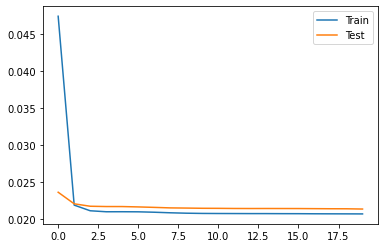

In [76]:
# Train the Neural Network
start = datetime.now()

hyperparams = {'activation':'linear', 'npl':100, 
               'loss':'mae', 'optimizer':'Adam',
               'metric':'mse', 'epochs':20,
               'numhidlayers':2,'validation_split':0.2,
               'use_bias':True}

model, history = ANN(x_train, y_train, n_pc, **hyperparams)

print('ANN training time:',datetime.now()-start)

# plot history
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

In [77]:
ypred_ANN = np.zeros((n_train-1, n_pc))

for k in range(n_train-1):
    ypred_ANN[k,:] = model.predict(np.reshape(x_train[k,:], [1,-1]), batch_size=1)

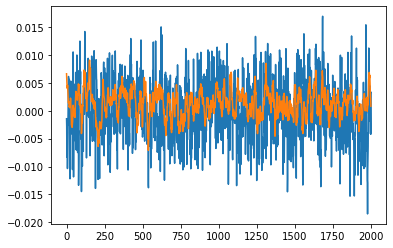

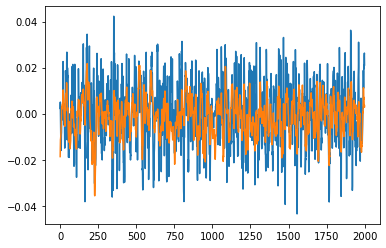

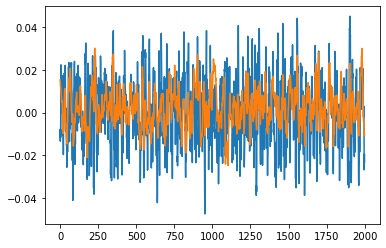

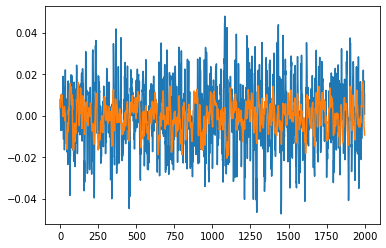

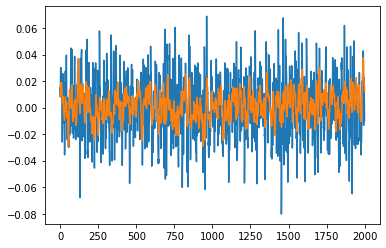

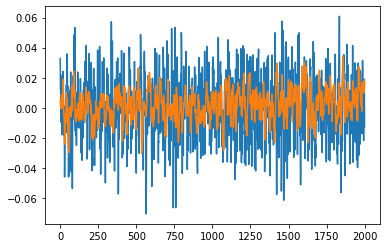

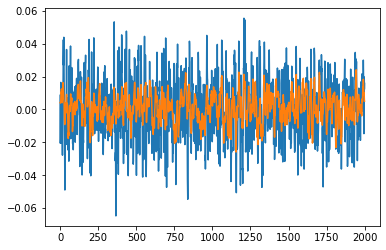

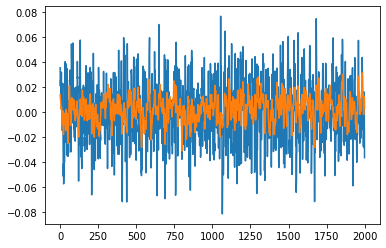

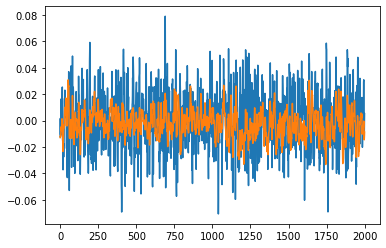

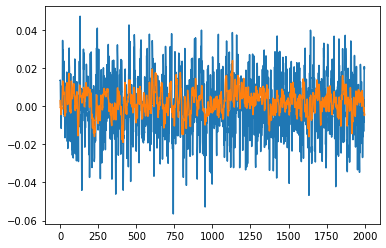

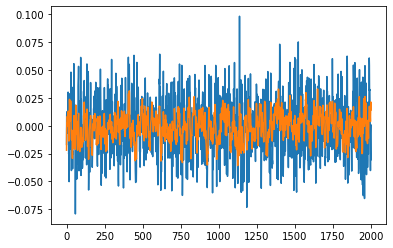

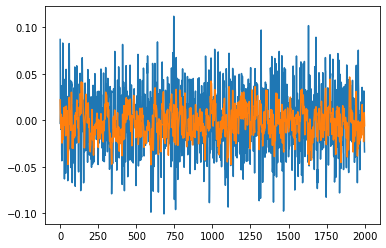

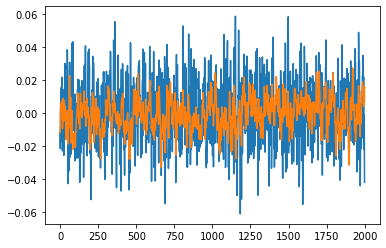

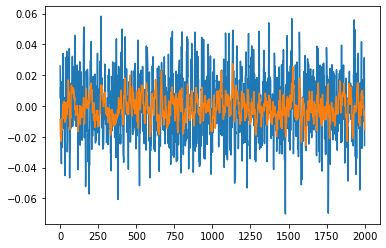

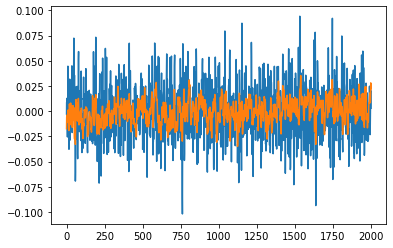

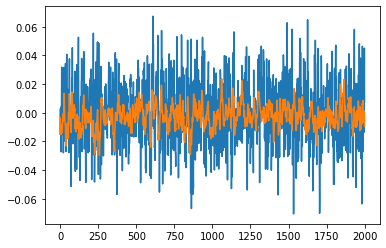

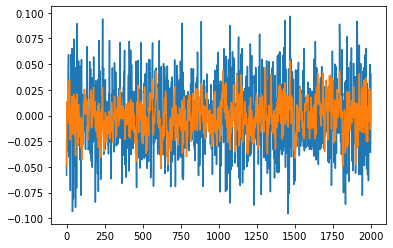

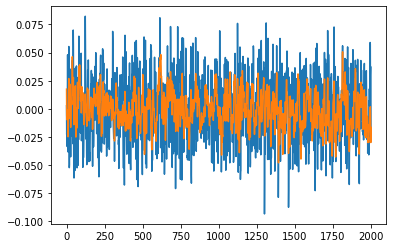

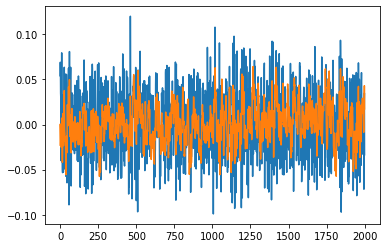

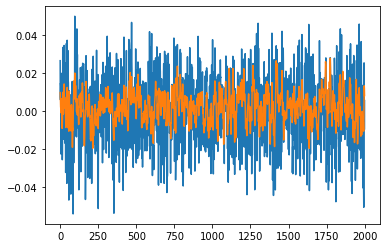

In [78]:
for k in range(20):
    plt.plot(y_train[:2000,k])
    plt.plot(ypred_ANN[:2000,k])
    plt.show()

In [79]:
# compute ANN residuals
residual = y_train - ypred_ANN
np.std(residual, axis=0)

array([0.00529222, 0.01140132, 0.01297739, 0.0140127 , 0.01957196,
       0.01793513, 0.01586346, 0.02054196, 0.0191647 , 0.01427403,
       0.02121718, 0.02691045, 0.01655902, 0.01861109, 0.02380717,
       0.01947719, 0.02722863, 0.02419597, 0.03120457, 0.01555666,
       0.01673961, 0.01675048, 0.02303383, 0.02682471, 0.02869982,
       0.02691253, 0.02993467, 0.02659207, 0.02746807, 0.02636876,
       0.0270356 , 0.02207919, 0.02178309, 0.02385978, 0.01812093,
       0.0246532 , 0.02794337, 0.01896994, 0.02156639, 0.0290091 ,
       0.02674245, 0.0235879 , 0.03019611, 0.02380854, 0.02339519,
       0.02629356, 0.025491  , 0.02346673, 0.02359292, 0.02951669,
       0.02533025, 0.02761371, 0.02527655, 0.02411465, 0.03103484,
       0.02198132, 0.02429597, 0.02287777, 0.02162403, 0.02535954,
       0.0293611 , 0.02277831, 0.02505576, 0.02682517, 0.02259648,
       0.02307015, 0.02377693, 0.0257283 , 0.02386187, 0.02807615,
       0.02836018, 0.02368851, 0.02481308, 0.02801305, 0.02758

In [ ]:
np.save('Psi1_150PCs_pureANN_training_residuals_std_dev_mimicLR_ntrain=400K')

In [102]:
# Spatially correlated white noise
def spatialCorrWhtNoise(nt, npc, residual):
    dW = np.random.randn(nt, npc) # additive white noise
    covn = np.cov(residual.T) # Correlation coefficients
    rr = np.linalg.cholesky(covn)
    stdres = np.std(residual, axis=0)
    return dW.dot(rr.T)*stdres

In [103]:
def forecast_(n_pred, n_in_param, x_start, ann_model, scaler_x, dt, n_ensem=1, dW=None):
    y_pred = np.zeros((n_ensem, n_pred, n_in_param))
    temp = np.zeros((n_pred, n_in_param))
    state = np.zeros((1, n_in_param))
    
    for i in range(n_ensem):
        # Set the initial state
        state = x_start
    
        for j in range(n_pred):
            # Use ANN to predict the state
            tend = ann_model.predict(state, batch_size=1)
        
            # store the new state in the output
            state = tend*dt+state
            temp[j,:] = state[:]
        
        y_pred[i,:,:] = scaler_x.inverse_transform(temp)
    
    return y_pred

In [20]:
################################################################
##################### Short term forecasts #####################
################################################################
n_maxlead = 10  # Prediction of 20 records for each realization
n_ic = int((n_test - n_maxlead))    # Number of initial conditions 
n_ensem = 100
y_pred = np.zeros([n_ic, n_ensem, n_maxlead, n_pc])
isnoise = False
test_dataN = scaler.transform(test_data)

start = datetime.now()
for k in range(n_ic):
    # initial conditions
    x_start = test_dataN[k,:].reshape(1,-1)
    
    if isnoise:
        # generate the noise for all ensembles
        dW = spatialCorrWhtNoise(n_ensem*n_maxlead, n_pc, residual)
    else:
        # set zero values to the noise component
        dW = np.zeros((n_ensem*n_maxlead, n_pc))
    
    # produce forecasts
    y_pred[k,:,:,:] = forecast_(n_maxlead,n_pc,x_start,
                               model,scaler,dt,n_ensem,dW)

enMean_y_pred = np.mean(y_pred, axis=1)
print('Prediction time:', datetime.now()-start)
print('Number of realizations obtained:',n_ic)
print('Prediction length of each realization:',n_maxlead)

Prediction time: 1:43:05.173129
Number of realizations obtained: 9990
Prediction length of each realization: 10


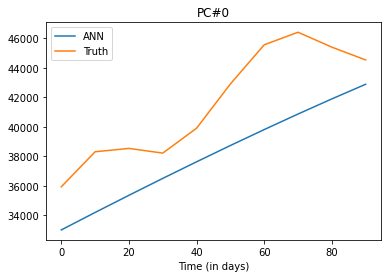

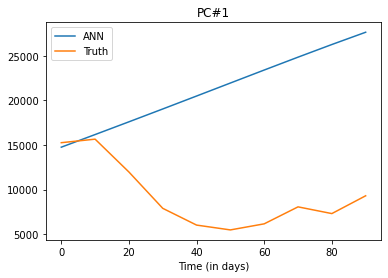

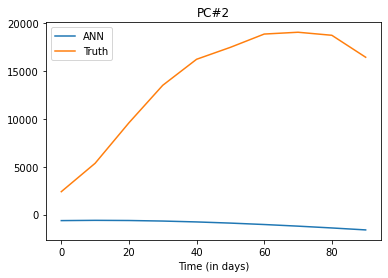

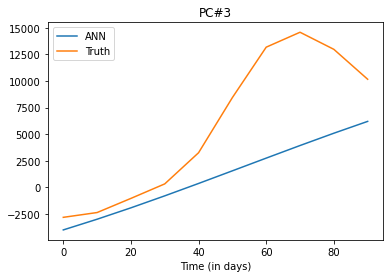

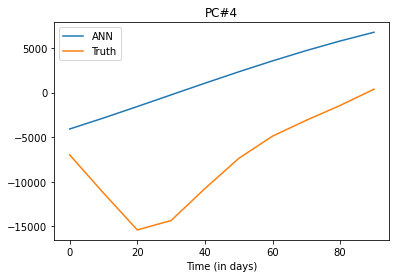

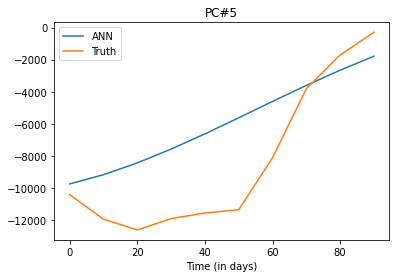

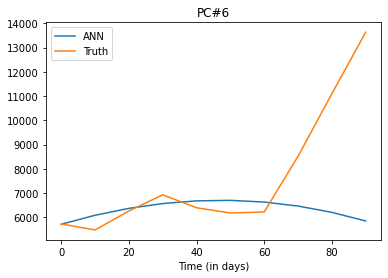

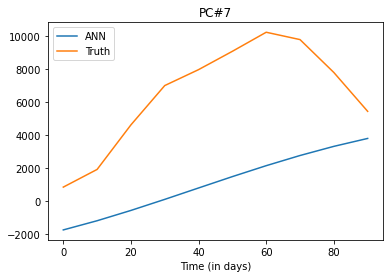

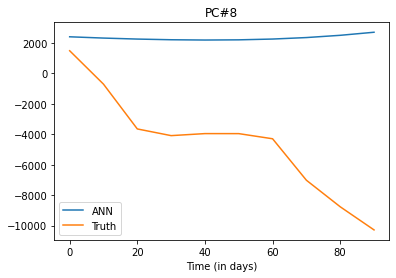

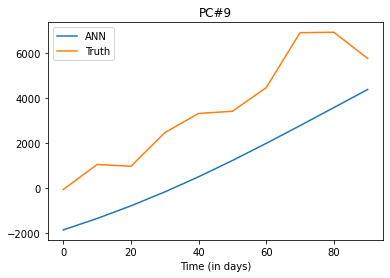

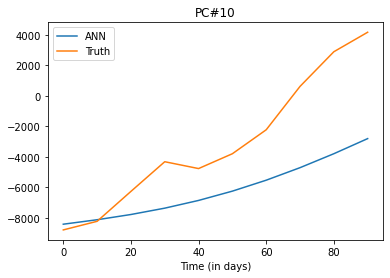

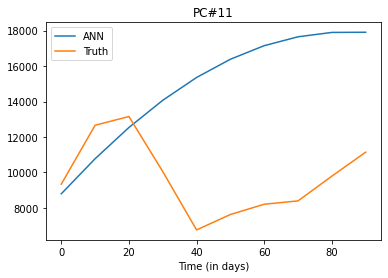

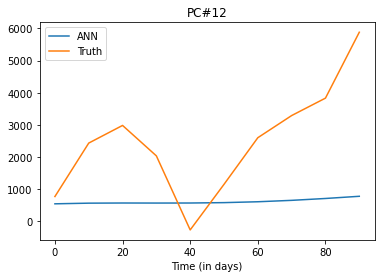

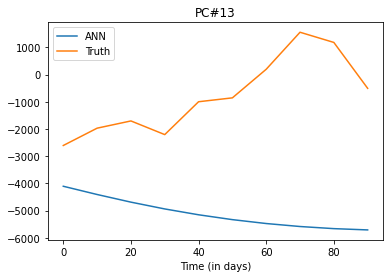

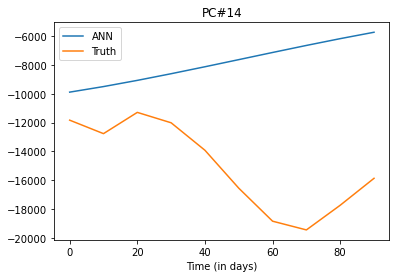

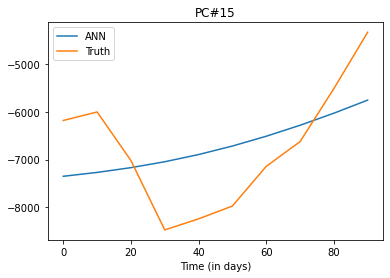

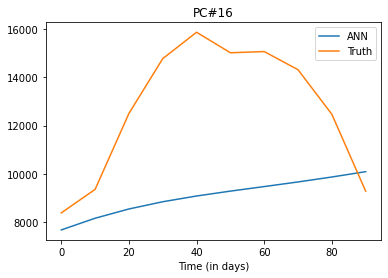

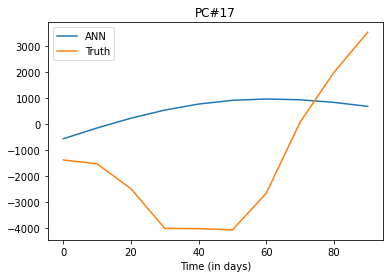

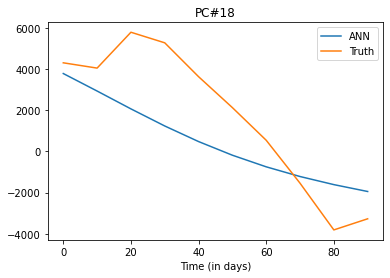

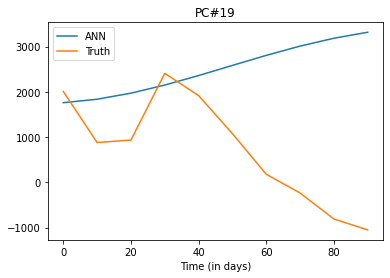

In [21]:
# Plot the predicted results against the truth for any initial condition
ic = 0       # IC index; should be 0,1,2,3..., nic-1 
for k in range(20):
    plt.figure()
    x = np.arange(0,n_maxlead*dt,10)
    plt.plot(x,enMean_y_pred[ic,:,k],label='ANN')
    true_ = test_data[ic+1:ic+n_maxlead+1,k]
    plt.plot(x,true_,label='Truth')
    plt.xlabel('Time (in days)')
    plt.title('PC#'+str(k))
    plt.legend()
    plt.show()

In [22]:
####################################################################
############ Metric 1 : RMSE on the physical space #################
###### Use each data point of the test dataset as an IC ############
## Obtain 100 stochastic realizations (if applicable) for each IC ##
####################################################################
# Project the modelled PCs onto the EOFs and calculate mean RMSE
rmse = np.zeros((n_ic, n_maxlead))
start = datetime.now()
# start a parallel pool and implement thread parallelism
if __name__ == "__main__":
    rmse = Parallel(n_jobs=num_cores, prefer="threads")(delayed(RMSE)(i,test_data,enMean_y_pred,eofs,n_maxlead) for i in tqdm(range(n_ic)))
    
meanRMSE = np.mean(rmse, axis=0)

100%|██████████| 9990/9990 [10:18<00:00, 16.14it/s]


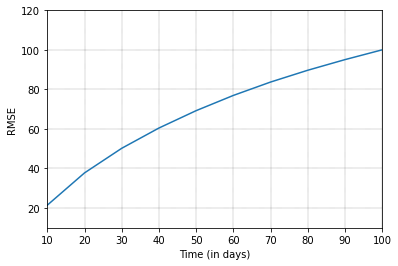

In [23]:
# Plot the mean RMSE
plt.plot(np.arange(dt,n_maxlead*dt+1,dt),meanRMSE)
plt.xlabel('Time (in days)')
plt.ylabel('RMSE')
plt.ylim([10, 120])
plt.xlim([dt, n_maxlead*dt])
plt.grid(color='k', linestyle='--', linewidth=0.2)
plt.savefig('RMSE_Psi1_100days_predictions_pureANN_mimicLR_npc=150_nic=9995_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()
np.save('RMSE_Psi1_50days_predictions_pureANN_mimicLR_npc=150_nic=9995_ntrain=400K_ntest=100K',meanRMSE)

In [17]:
####################################################################
# Metric 2a : Instantaneous temporal correlation coefficient (ITCC) #
####################################################################
itcc = np.zeros((n_ic, nx*ny))

start = datetime.now()
if __name__ == "__main__":
    itcc = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,enMean_y_pred,eofs,n_maxlead,'temporal') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)
meanitcc = np.mean(itcc, axis=0)

100%|██████████| 9995/9995 [13:16<00:00, 12.54it/s]


Time taken: 0:13:19.568824


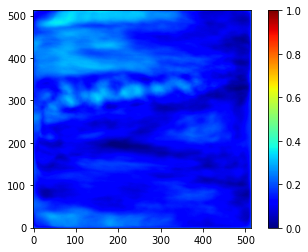

In [19]:
plt.imshow(meanitcc.reshape(nx,ny), origin='lower',cmap='jet')
plt.colorbar()
plt.clim([0, 1])
plt.savefig('ITCC_Psi1_50days_predictions_pureANN_npc=150_nic=9995_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()
np.save('ITCC_Psi1_50days_predictions_pureANN_npc=150_nic=9995_ntrain=400K_ntest=100K',meanitcc)

In [20]:
####################################################################
# Metric 2b : Instantaneous spatial correlation coefficient (ISCC) #
####################################################################
iscc = np.zeros((n_ic, nx*ny))

start = datetime.now()
if __name__ == "__main__":
    iscc = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,enMean_y_pred,eofs,n_maxlead,'spatial') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)
meaniscc = np.mean(iscc, axis=0)

100%|██████████| 9995/9995 [10:35<00:00, 15.73it/s]


Time taken: 0:10:38.484043


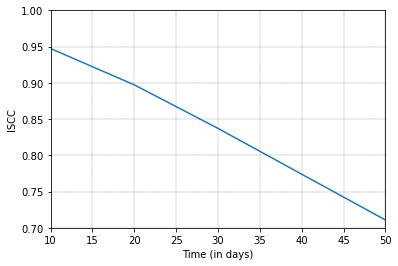

In [22]:
plt.plot(np.arange(dt,n_maxlead*dt+1,dt), meaniscc)
plt.xlabel('Time (in days)')
plt.ylabel('ISCC')
plt.xlim([dt, n_maxlead*dt])
plt.ylim([0.7, 1])
plt.grid(color='k', linestyle='--', linewidth=0.2)
plt.savefig('ISCC_Psi1_50days_predictions_pureANN_npc=150_nic=9995_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()
np.save('ISCC_Psi1_50days_predictions_pureANN_npc=150_nic=9995_ntrain=400K_ntest=100K',meaniscc)

In [104]:
################################################################
################### Long term forecasts ########################
################################################################
n_maxlead = 20000  # Prediction of 1000 records for each realization
n_ic = 1    # Number of initial conditions 
isnoise = False
n_ensem = 1
y_pred = np.zeros([n_ic, n_ensem, n_maxlead, n_pc])
test_dataN = scaler.transform(test_data)

start = datetime.now()
if isnoise:
    # generate the noise for all ensembles
    dW = spatialCorrWhtNoise(n_ensem*n_maxlead, n_pc, residual)
else:
    # set zero values to the noise component
    dW = np.zeros((n_ensem*n_maxlead, n_pc))
    
print('Noise generation time:',datetime.now()-start)

start = datetime.now()
for k in range(n_ic):
    # initial conditions
    x_start = test_dataN[k,:].reshape(1,-1)
    
    # produce forecasts
    y_pred[k,:,:,:] = forecast_(n_maxlead,n_pc,x_start,
                               model,scaler,dt,n_ensem,dW)

enMean_y_pred = np.mean(y_pred, axis=1)
print('Prediction time:', datetime.now()-start)
print('Number of realizations obtained:',n_ic)
print('Prediction length of each realization:',n_maxlead)

Noise generation time: 0:00:00.000357
Prediction time: 0:00:14.625689
Number of realizations obtained: 1
Prediction length of each realization: 20000


In [105]:
###### Time complexity ######
# Pure ANN
# Training time = ANN training (135sec for 50 epochs)
# Prediction time = time to produce one 10K days realization using one initial condition(0.8sec)
# ANN + Noise
# Training time = ANN training (135sec for 50 epochs) + time to calculate the standard deviations of ANN residuals (0.2sec)
# Prediction time = time to produce one 10K days realization using one initial condition(0.7sec)+ noise generation time (0.1)

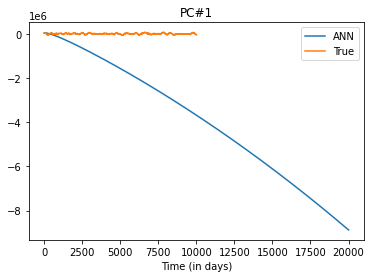

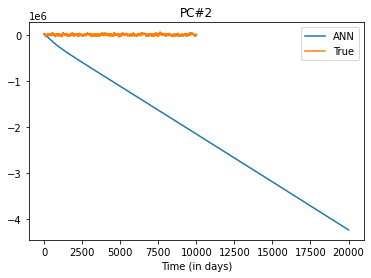

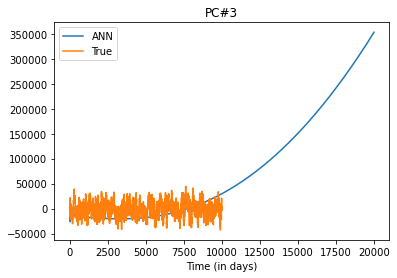

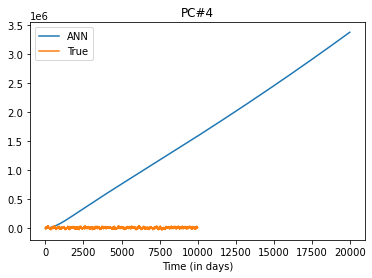

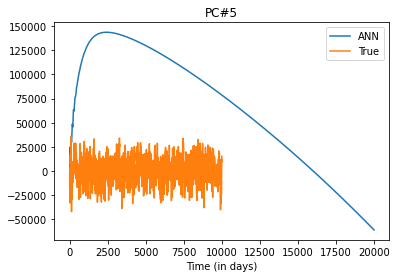

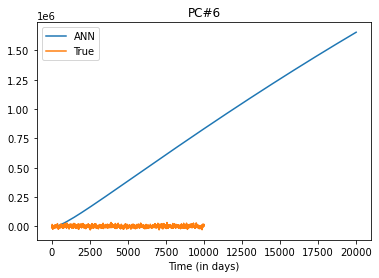

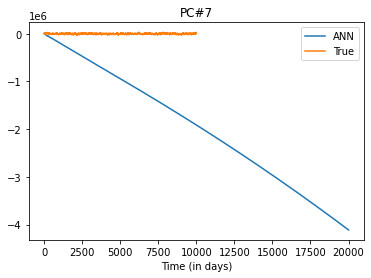

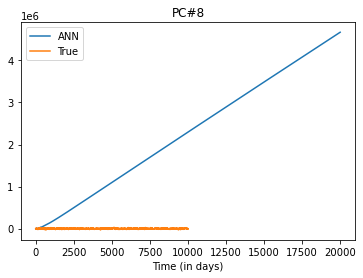

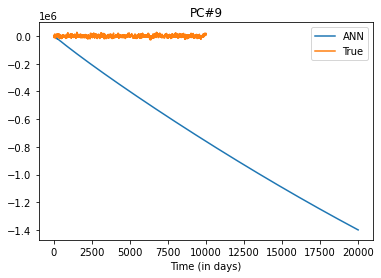

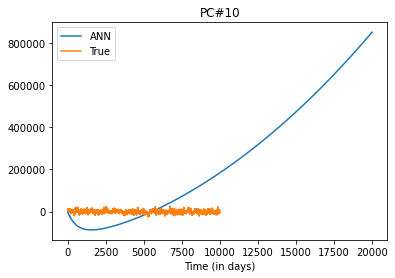

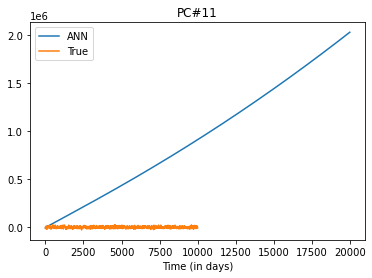

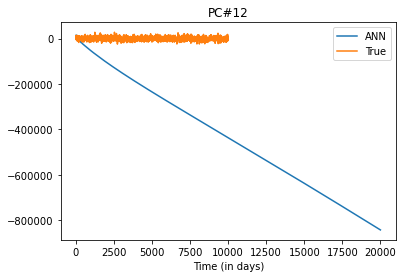

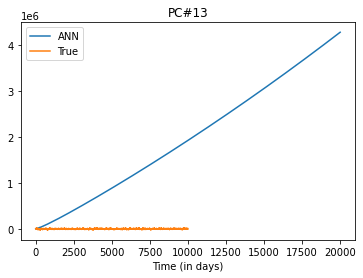

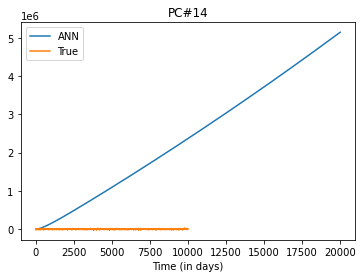

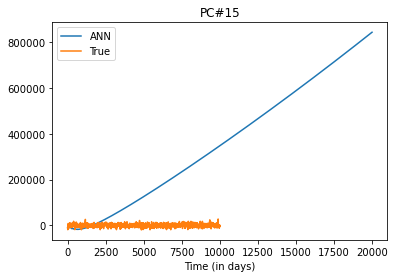

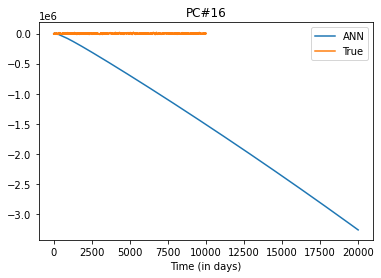

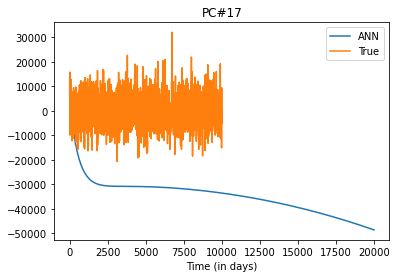

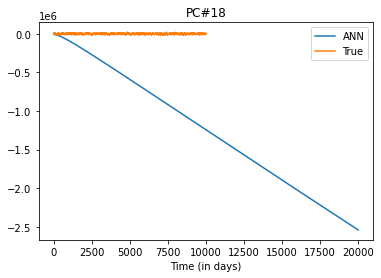

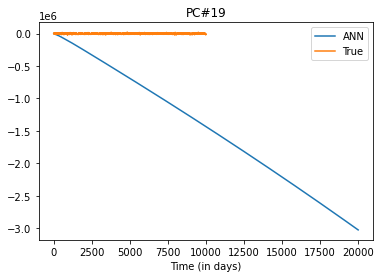

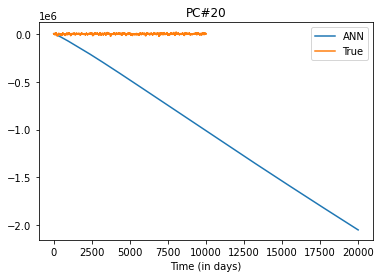

In [106]:
# Plot the predicted results against the truth
ic = 0       # Should be 0,1,2,3...,nic-1
for k in range(20):
    plt.figure()
    x = np.arange(dt,n_maxlead*dt+1,dt)
    plt.plot(enMean_y_pred[ic,:,k],label='ANN')
    plt.plot(test_data[ic+1:ic+1+n_maxlead,k],label='True')
    plt.title('PC#' + str(k+1))
    plt.xlabel('Time (in days)')
    plt.legend()
    plt.show()

In [19]:
################################################################
############# Metric 3 : Climatology and Variance ##############
######### using multiple realizations of 10,000 days  #########
################################################################
psi1_climatology_pred = np.zeros((n_ic,nx*ny))
psi1_variance_pred = np.zeros((n_ic,nx*ny))

# Project the modelled PCs onto the EOFs and calculate climatology
for kk in range(n_ic):
    psi1_pred = np.float32(enMean_y_pred[kk,:,:]).dot(np.float32(eofs))
    psi1_climatology_pred[kk,:] = np.mean(psi1_pred, axis=0)
    psi1_variance_pred[kk,:] = np.var(psi1_pred, axis=0)

mean_psi1_climatology_pred = np.mean(psi1_climatology_pred, axis=0)
mean_psi1_variance_pred = np.mean(psi1_variance_pred, axis=0)

MemoryError: Unable to allocate 19.6 GiB for an array with shape (20000, 263169) and data type float32

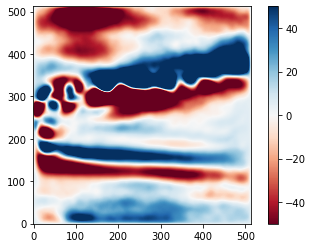

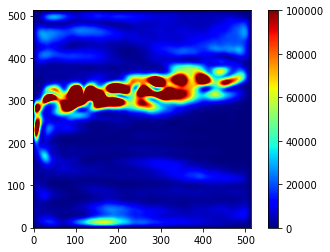

In [29]:
# Climatology and variance of the predictions
plt.imshow(mean_psi1_climatology_pred.reshape(nx,ny), origin='lower', cmap='RdBu')
plt.clim(-20, 20)
plt.colorbar()
#plt.savefig('Climatology_Psi1_10Kdays_predictions_pureANN_npc=150_nic=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()

plt.imshow(mean_psi1_variance_pred.reshape(nx,ny), origin='lower', cmap='jet')
plt.clim(0, 100000)
plt.colorbar()
#plt.savefig('Variance_Psi1_10Kdays_predictions_pureANN_npc=150_nic=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()

In [30]:
##################################################
############# Metric 4: Frequency map ############
####### frequency = 1/decorrelation time #########
##################################################
freq_pred = np.zeros((n_ic,nx*ny))

for kk in range(n_ic):
    psi1_pred = enMean_y_pred[kk,:,:].dot(eofs)
    start = datetime.now()
    if __name__ == "__main__":
        freq_ = Parallel(n_jobs=num_cores, prefer="threads")(delayed(frequency)(i,psi1_pred,dt) for i in tqdm(range(nx*ny)))
    freq_pred[kk,:] = freq_
    print('Time taken:',datetime.now()-start)
    
# mean frequency
mean_freq_pred = np.mean(freq_pred, axis=0)

100%|██████████| 263169/263169 [02:36<00:00, 1678.29it/s]


Time taken: 0:02:36.954258


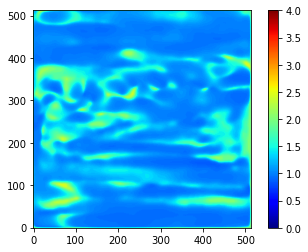

In [31]:
plt.imshow(np.array(mean_freq_pred).reshape(nx,ny), origin='lower', cmap='jet')
plt.colorbar()
plt.clim([0,4])
plt.savefig('Frequency_Psi1_10Kdays_predictions_pureANN_npc=150_nic=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.show()